Exploratory data analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

image_dir = 'dataset/US_liver_data/US_liver_img_sep_2022'
annotations_dir = 'dataset/US_liver_data/annotations/Liver_Elastography_annotations_Sheba.xlsx'

In [14]:
# Initialize the database
database = {}
# Loop over the images in the directory
for filename in os.listdir(image_dir):
    # Extract the name prefix from the filename
    name_prefix = filename.split('.')[0]

    # Add the image path to the list of images for the name prefix
    if name_prefix not in database:
        database[name_prefix] = []
    database[name_prefix].append(os.path.join(image_dir, filename))

print(len(list(database.keys())))

697


In [3]:
df = pd.read_excel('dataset/US_liver_data/annotations/Liver_Elastography_annotations_Sheba.xlsx').drop(columns=['טבלת המרה', 'liver biopsy', 'underlying conditions', 'deceased', 'gender'])
df['Accession_number'] = df['Accession_number'].astype(str)

# since there arent any duplicates, we drop the elastography date as well
if not df['Accession_number'].duplicated().any():
    df.drop(columns='Elastography Date', inplace=True)

df.head()

,Accession_number,birthdate,BMI,fibrosis score,Kilopascal
0,4015009301008,1944-04-09 00:00:00,35.050,2,7.1-8.4
1,4015007487057,1950-01-01 00:00:00,26.446,0,5.7-6.4
2,4015008849573,1950-01-01 00:00:00,26.446,0,5.3-6.4
3,4015010341175,1950-01-01 00:00:00,26.446,0,7.1-9.9
4,4015010798265,1950-03-24 00:00:00,34.964,3,9.3-13


Autocomplete NaN values in the BMI and convert to age

In [4]:
from sklearn.impute import SimpleImputer
import datetime

# check the number of nans in each column
print(f"the number of NaN BMI scores are: {df['BMI'].isnull().sum()}")

columns = ['BMI']
imputer = SimpleImputer(strategy='mean')
# Fit the imputer to the selected columns
df_selected = df.loc[:, columns]
imputer.fit(df_selected)

# Transform the selected columns to fill missing values and assign the result to the original DataFrame
df.loc[:, columns] = imputer.transform(df_selected)

# Define a function that calculates the age in years
def calculate_age(birth_date):
  try:
    return (datetime.datetime.now() - birth_date).days // 365
  except Exception:
    return 0
  
# Apply the function to the 'birth_date' column
df['birthdate'] = df['birthdate'].apply(calculate_age)

df.head()


the number of NaN BMI scores are: 892


,Accession_number,birthdate,BMI,fibrosis score,Kilopascal
0,4015009301008,78,35.050,2,7.1-8.4
1,4015007487057,73,26.446,0,5.7-6.4
2,4015008849573,73,26.446,0,5.3-6.4
3,4015010341175,73,26.446,0,7.1-9.9
4,4015010798265,72,34.964,3,9.3-13


Divide into two datasets to try two methods of classification. First is to predict fibrosis from kilopascal measurements. Second is to predict kilopascal from image

In [5]:
# filter out to get only lines we have images for, and only ones that have the actual radiology score
dual_df = df[df['Accession_number'].isin(list(database.keys())) & ~df['fibrosis score'].isnull() & ~(df['fibrosis score']=='technical problem') & ~df['Kilopascal'].isnull()].rename(columns={'fibrosis score': 'label'})

dual_df['label'] = dual_df['label'].astype(str)
dual_df['Kilopascal'] = dual_df['Kilopascal'].astype(str)

dual_df.head()

,Accession_number,birthdate,BMI,label,Kilopascal
0,4015009301008,78,35.050,2,7.1-8.4
1,4015007487057,73,26.446,0,5.7-6.4
2,4015008849573,73,26.446,0,5.3-6.4
5,4015008135215,82,38.104,0-1,5.8-7
6,4015007938194,75,29.321,0,5.7-6.1


convert all fibrosis scores into ranges, we treat the fs dataset as a classification problem

In [6]:
def fs_label(row):
    row['label'] = f'{row["label"]}-{row["label"]}'
    return row

def kp_label(row):
    labels = [float(label) for label in row.split('-')]
    try:
        return labels[0] + labels[1] / 2
    except Exception:
        return labels[0]

dual_df['Kilopascal'] = dual_df['Kilopascal'].apply(kp_label)
dual_df.loc[~(dual_df['label'].str.contains('-')), :] = dual_df.loc[~(dual_df['label'].str.contains('-')), :].apply(fs_label, axis=1)
dual_df['Accession_number'] = dual_df['Accession_number'].astype(int)
dual_df

,Accession_number,birthdate,BMI,label,Kilopascal
0,4015009301008,78,35.050000,2-2,11.30
1,4015007487057,73,26.446000,0-0,8.90
2,4015008849573,73,26.446000,0-0,8.50
5,4015008135215,82,38.104000,0-1,9.30
6,4015007938194,75,29.321000,0-0,8.75
...,...,...,...,...,...
236,4015008100496,56,27.718000,0-0,7.90
238,4015009370381,55,28.409000,1-1,10.15
242,4015009138700,54,29.432624,3-4,15.05
245,4015008780896,55,29.432624,1-2,10.65


Split into a train and test sets

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the string labels as integer labels
encoder = LabelEncoder()
dual_df['label'] = encoder.fit_transform(dual_df['label'])
np.random.seed(22)

train_df, test_df = train_test_split(dual_df.sample(frac=1, random_state=22))
print(len(train_df), len(test_df))
# since the data is imbalanced, well later use the micro-averaged f1-score
print(f"train class balance: \n{train_df['label'].value_counts()}")
print(f"test class balance: \n{test_df['label'].value_counts()}")

120 41
train class balance: 
0    48
8    24
4    14
3     8
1     7
5     6
7     6
6     4
2     3
Name: label, dtype: int64
test class balance: 
0    18
8     6
4     5
7     4
6     3
5     2
1     2
2     1
Name: label, dtype: int64


## Train with XGboost

In [8]:
import xgboost as xgb
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report

# split classes into weights
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=train_df['label'])

# Define a model for a binary classification problem
model = xgb.XGBClassifier()
# Train the model
model.fit(train_df.drop(columns='label'), train_df['label'], sample_weight=classes_weights)
# Make predictions on the validation set
predictions = model.predict(test_df.drop(columns='label'))
# Calculate the accuracy of the predictions
# accuracy = accuracy_score(test_df['label'], predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# calculate the micro averaged f1-score
# f1 = f1_score(test_df['label'], predictions, average='micro')
# print(f"f1-score: {f1}")
# get full report
print(classification_report(test_df['label'], predictions, zero_division=True))

[18:55:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/data/home/pelegdav/env/autoML/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/data/home/pelegdav/env/autoML/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/pelegdav/env/autoML/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(d

              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.33      0.50      0.40         2
           2       0.00      0.00      0.00         1
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         2
           6       1.00      0.00      0.00         3
           7       0.75      0.75      0.75         4
           8       0.86      1.00      0.92         6

    accuracy                           0.78        41
   macro avg       0.71      0.64      0.60        41
weighted avg       0.83      0.78      0.76        41



## Remove fibrosis scores and create a regression problem to predict KiloPascal from images

In [58]:
kp_df = dual_df.drop(columns='label').rename(columns={'Kilopascal': 'label'}).set_index('Accession_number')
kp_df

,birthdate,BMI,label
Accession_number,,,
4015009301008,78,35.050000,11.30
4015007487057,73,26.446000,8.90
4015008849573,73,26.446000,8.50
4015008135215,82,38.104000,9.30
4015007938194,75,29.321000,8.75
...,...,...,...
4015008100496,56,27.718000,7.90
4015009370381,55,28.409000,10.15
4015009138700,54,29.432624,15.05


Create a custom dataloader

In [64]:
import torch
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms


# Define a custom dataset
class ImageDataset(data.Dataset):
  def __init__(self, database, kp_df):
    # Get a list of image file paths
    self.key_enumerator = {i: key for i, key in enumerate(list(kp_df.index))}
    self.file_path_dict = database
    self.kp_df = kp_df
    self.transform = transforms.ToTensor()


  def __len__(self):
    # Return the number of data points
    return len(list(self.key_enumerator.keys()))

  def __getitem__(self, index):
    accession = self.key_enumerator[index]
    # Open the image and return the image and its file path
    images = [self.transform(Image.open(path)) for path in self.file_path_dict[str(accession)]]
    label = self.kp_df.loc[accession, 'label']
    return images, label

# Create a dataset object
dataset = ImageDataset(database, kp_df)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = data.random_split(dataset, [train_size, test_size])

# Create train and test data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

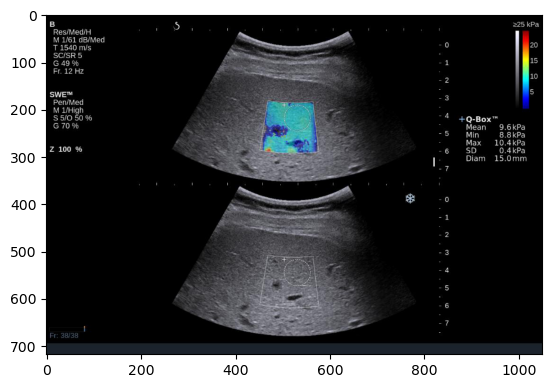

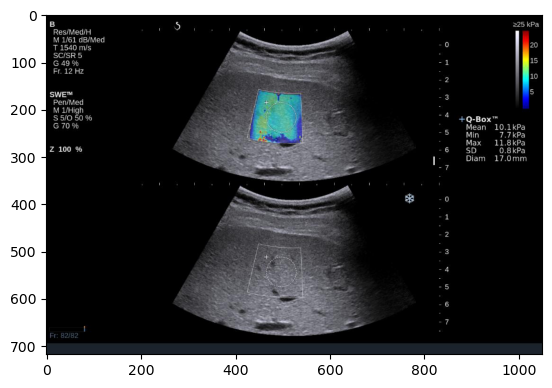

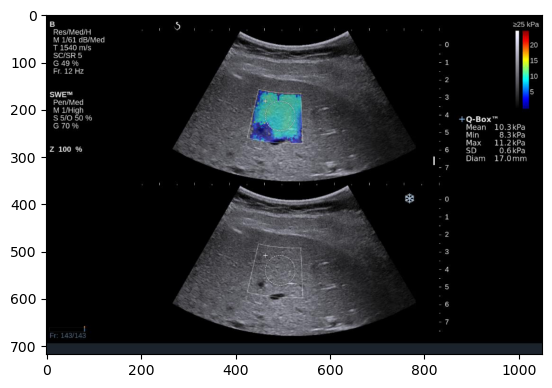

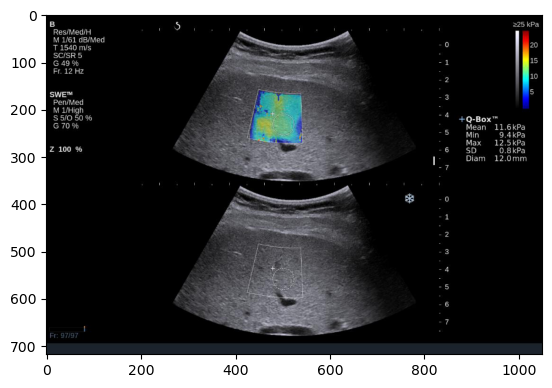

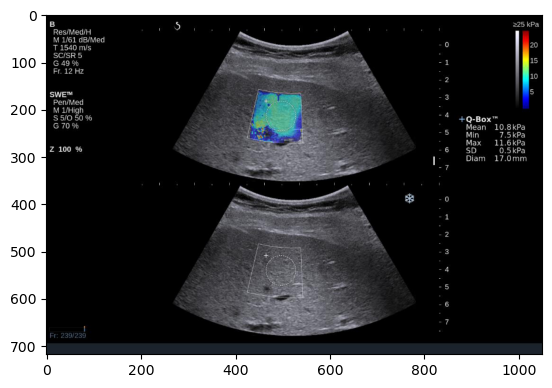

In [82]:
temp_batch, label = next(train_loader.__iter__())
# Define the transformation to convert the tensor to a PIL image
transform = transforms.ToPILImage()

for im in temp_batch:
    plt.figure()
    # Convert the tensor to a PIL image
    plt.imshow(transform(im.squeeze(0)))


In [100]:
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm

# TODO extend by creating a neural network that holds all the images together

# Load the pre-trained ResNet34 model
model = models.resnet34(pretrained=True)

# Replace the fully-connected layer with a new fully-connected layer with a single output
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=1)

model = model.cuda()
# Define the loss function and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for inputs, targets in tqdm(train_loader):
  try:
    # Clear the gradients
    optimizer.zero_grad()

    # Make predictions
    outputs = torch.mean(torch.stack([model(input_img.cuda()) for input_img in inputs]), dim=0, keepdim=True, dtype=float)

    # Calculate the loss
    loss = loss_func(outputs, targets.cuda())

    # Backpropagate the loss
    loss.backward()

    # Update the model weights
    optimizer.step()
  except RuntimeError:
    print('error occured, need to investigate')
    continue

/data/home/pelegdav/env/autoML/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/data/home/pelegdav/env/autoML/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/128 [00:00<?, ?it/s]/data/home/pelegdav/env/autoML/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  retu

error occured, need to investigate


100%|██████████| 128/128 [00:37<00:00,  3.43it/s]


Repeat the same thing with ConvNext from hugging face

In [99]:
# from transformers import ConvNextImageProcessor, ConvNextModel, preprocessing
# import torch
# from datasets import load_dataset

# from PIL import Image

# # Open and resize the image
# image = Image.open('image.jpg').resize((224, 224))
# # Convert the image to a tensor
# tensor = preprocessing.image.to_tensor(image)
# # Add a batch dimension to the tensor
# tensor = tensor.unsqueeze(0)
# # Normalize the tensor
# tensor = preprocessing.image.normalize_tensor(tensor)
# # dataset = load_dataset(image_dir)
# # image = dataset["test"]["image"][0]

# feature_extractor = ConvNextImageProcessor.from_pretrained("facebook/convnext-tiny-224")
# model = ConvNextModel.from_pretrained("facebook/convnext-tiny-224")

# inputs = feature_extractor(image, return_tensors="pt")

# with torch.no_grad():
#     outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state
# list(last_hidden_states.shape)